In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of classes
SIC_class_count = 12
SOD_class_count = 6
FLOE_class_count = 7

# Generate class names
SIC_classes = [f'{i}' for i in range(SIC_class_count)]
SOD_classes = [f'{i}' for i in range(SOD_class_count)]
FLOE_classes = [f'{i}' for i in range(FLOE_class_count)]

# Generate the palette using 'jet' colormap
total_classes = SIC_class_count + SOD_class_count + FLOE_class_count
cmap = plt.get_cmap('jet', total_classes)

# Create a palette with colors for each class
palette = (cmap(np.linspace(0, 1, total_classes))[:, :3] * 255).astype(int).tolist()

# Split the palette according to the classes
SIC_palette = palette[:SIC_class_count]
SOD_palette = palette[SIC_class_count:SIC_class_count + SOD_class_count]
FLOE_palette = palette[SIC_class_count + SOD_class_count:]

# Construct METAINFO dictionary
METAINFO = {
    'SIC_classes': SIC_classes,
    'SOD_classes': SOD_classes,
    'FLOE_classes': FLOE_classes,
    'SIC_palette': SIC_palette,
    'SOD_palette': SOD_palette,
    'FLOE_palette': FLOE_palette
}

# Output the METAINFO dictionary
METAINFO


{'SIC_classes': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
 'SOD_classes': ['0', '1', '2', '3', '4', '5'],
 'FLOE_classes': ['0', '1', '2', '3', '4', '5', '6'],
 'SIC_palette': [[0, 0, 127],
  [0, 0, 175],
  [0, 0, 224],
  [0, 0, 255],
  [0, 42, 255],
  [0, 85, 255],
  [0, 127, 255],
  [0, 169, 255],
  [0, 212, 255],
  [20, 255, 226],
  [54, 255, 191],
  [89, 255, 157]],
 'SOD_palette': [[123, 255, 123],
  [157, 255, 89],
  [191, 255, 54],
  [226, 255, 20],
  [255, 229, 0],
  [255, 190, 0]],
 'FLOE_palette': [[255, 151, 0],
  [255, 111, 0],
  [255, 72, 0],
  [255, 33, 0],
  [224, 0, 0],
  [175, 0, 0],
  [127, 0, 0]]}

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""Converts polygon icechart in the raw ASIP3 challenge dataset to SIC, SOD and FLOE charts."""

# -- File info -- #
__author__ = 'Andreas R. Stokholm'
__contributors__ = 'Tore Wulf'
__copyright__ = ['Technical University of Denmark', 'European Space Agency']
__contact__ = ['stokholm@space.dtu.dk']
__version__ = '0.0.1'
__date__ = '2022-09-20'

# -- Built-in modules -- #
import copy

# -- Third-party modules -- #
import numpy as np
import xarray as xr
from PIL import Image

# -- Proprietary modules -- #
from AI4ArcticSeaIceChallenge.utils import CHARTS, SIC_LOOKUP, SOD_LOOKUP, FLOE_LOOKUP, ICE_STRINGS, GROUP_NAMES, ICECHART_NOT_FILLED_VALUE, ICECHART_UNKNOWN, LOOKUP_NAMES


def convert_polygon_icechart(scene):
    """
    Original polygon_icechart in ASIP3 scenes consists of codes to a lookup table `polygon_codes`.

    This function looks up codes and converts them. 3 variables in the xr scene are created; SIC, SOD and FLOE.
    For SOD and FLOE the partial sea ice concentration is used to determine whether there is a dominant category in a polygon.
    The SOD and FLOE are created using the lookup tables in utils, which dictate the conversion from ice code to class, As multiple codes can be
    converted into a single class, these partial concentrations must also be added. In addition, empty codes, 'not filled values' and unknowns are
    replaced appropriately.

    Parameters
    ----------
    scene :
        xarray dataset; scenes from the ASIP3 challenge dataset.
    """
    # Get codes from polygon_codes.
    codes = np.stack(np.char.split(scene['polygon_codes'].values.astype(str), sep=';'), 0)[SIC_LOOKUP['total_sic_idx']:, :]
    poly_type = np.stack((codes[:, 0] , codes[:, -1]))
    codes = codes[:, :-2].astype(int) 

    # Convert codes to classes for Total and Partial SIC.
    converted_codes = copy.deepcopy(codes)
    for key, value in SIC_LOOKUP.items():
        if type(key) == int:
            for partial_idx in SIC_LOOKUP['sic_partial_idx']:
                tmp = converted_codes[:, partial_idx]
                if key in tmp:
                    converted_codes[:, partial_idx][np.where((tmp == key))] = value

            tmp = converted_codes[:, SIC_LOOKUP['total_sic_idx']]
            if key in tmp:
                converted_codes[:, SIC_LOOKUP['total_sic_idx']][np.where((tmp == key))[0]] = value

    # Find where partial concentration is empty but total SIC exist.
    ice_ct_ca_empty = np.logical_and(
        converted_codes[:, SIC_LOOKUP['total_sic_idx']] > SIC_LOOKUP[0],
        converted_codes[:, SIC_LOOKUP['sic_partial_idx'][0]] == ICECHART_NOT_FILLED_VALUE)
    # Assign total SIC to partial concentration when empty.
    converted_codes[:, SIC_LOOKUP['sic_partial_idx'][0]][ice_ct_ca_empty] = \
            converted_codes[:, SIC_LOOKUP['total_sic_idx']][ice_ct_ca_empty]

    # Convert codes to classes for partial SOD.
    for key, value in SOD_LOOKUP.items():
        if type(key) == int:
            for partial_idx in SOD_LOOKUP['sod_partial_idx']:
                tmp = converted_codes[:, partial_idx]
                if key in tmp:
                    converted_codes[:, partial_idx][np.where((tmp == key))] = value

    # Convert codes to classes for partial FLOE.
    for key, value in FLOE_LOOKUP.items():
        if type(key) == int:
            for partial_idx in FLOE_LOOKUP['floe_partial_idx']:
                tmp = converted_codes[:, partial_idx]
                if key in tmp:
                    converted_codes[:, partial_idx][np.where((tmp == key))] = value

    # Get matching partial ice classes, SOD.
    sod_a_b_bool = converted_codes[:, SOD_LOOKUP['sod_partial_idx'][0]] == \
        converted_codes[:, SOD_LOOKUP['sod_partial_idx'][1]]
    sod_a_c_bool = converted_codes[:, SOD_LOOKUP['sod_partial_idx'][0]] == \
        converted_codes[:, SOD_LOOKUP['sod_partial_idx'][2]]
    sod_b_c_bool = converted_codes[:, SOD_LOOKUP['sod_partial_idx'][1]] == \
        converted_codes[:, SOD_LOOKUP['sod_partial_idx'][2]]

    # Get matching partial ice classes, FLOE.
    floe_a_b_bool = converted_codes[:, FLOE_LOOKUP['floe_partial_idx'][0]] == \
        converted_codes[:, FLOE_LOOKUP['floe_partial_idx'][1]]
    floe_a_c_bool = converted_codes[:, FLOE_LOOKUP['floe_partial_idx'][0]] == \
        converted_codes[:, FLOE_LOOKUP['floe_partial_idx'][2]]
    floe_b_c_bool = converted_codes[:, FLOE_LOOKUP['floe_partial_idx'][1]] == \
        converted_codes[:, FLOE_LOOKUP['floe_partial_idx'][2]]

    # Remove matches where SOD == -9 and FLOE == -9.
    sod_a_b_bool[np.where(converted_codes[:, SOD_LOOKUP['sod_partial_idx'][0]] == ICECHART_NOT_FILLED_VALUE)] = False
    sod_a_c_bool[np.where(converted_codes[:, SOD_LOOKUP['sod_partial_idx'][0]] == ICECHART_NOT_FILLED_VALUE)] = False
    sod_b_c_bool[np.where(converted_codes[:, SOD_LOOKUP['sod_partial_idx'][1]] == ICECHART_NOT_FILLED_VALUE)] = False
    floe_a_b_bool[np.where(converted_codes[:, FLOE_LOOKUP['floe_partial_idx'][0]] == ICECHART_NOT_FILLED_VALUE)] = False
    floe_a_c_bool[np.where(converted_codes[:, FLOE_LOOKUP['floe_partial_idx'][0]] == ICECHART_NOT_FILLED_VALUE)] = False
    floe_b_c_bool[np.where(converted_codes[:, FLOE_LOOKUP['floe_partial_idx'][1]] == ICECHART_NOT_FILLED_VALUE)] = False

    # Arrays to loop over to find locations where partial SIC will be combined for SOD and FLOE.
    sod_bool_list = [sod_a_b_bool, sod_a_c_bool, sod_b_c_bool]
    floe_bool_list = [floe_a_b_bool, floe_a_c_bool, floe_b_c_bool]
    compare_indexes = [[0, 1], [0, 2], [1,2]]

    # Arrays to store how much to add to partial SIC.
    sod_partial_add = np.zeros(converted_codes.shape)
    floe_partial_add = np.zeros(converted_codes.shape)

    # Loop to find
    for idx, (compare_idx, sod_bool, floe_bool) in enumerate(zip(compare_indexes, sod_bool_list, floe_bool_list)):
        tmp_sod_bool_indexes = np.where(sod_bool)[0]
        tmp_floe_bool_indexes = np.where(floe_bool)[0]
        if tmp_sod_bool_indexes.size:  #i.e. is array is not empty.
            sod_partial_add[tmp_sod_bool_indexes, SIC_LOOKUP['sic_partial_idx'][compare_idx[0]]] = \
                converted_codes[:, SIC_LOOKUP['sic_partial_idx'][compare_idx[1]]][tmp_sod_bool_indexes]

        if tmp_floe_bool_indexes.size:  # i.e. is array is not empty.
            floe_partial_add[tmp_floe_bool_indexes, SIC_LOOKUP['sic_partial_idx'][compare_idx[0]]] = \
                converted_codes[:, SIC_LOOKUP['sic_partial_idx'][compare_idx[1]]][tmp_floe_bool_indexes]

    # Create arrays for charts.
    scene_tmp = copy.deepcopy(scene['polygon_icechart'].values)
    sic = copy.deepcopy(scene['polygon_icechart'].values)
    sod = copy.deepcopy(scene['polygon_icechart'].values)
    floe = copy.deepcopy(scene['polygon_icechart'].values)

    # Add partial concentrations when classes have been merged in conversion (see SIC, SOD, FLOE tables).
    tmp_sod_added = converted_codes + sod_partial_add.astype(int)
    tmp_floe_added = converted_codes + floe_partial_add.astype(int)

    # Find and replace all codes with SIC, SOD and FLOE.
    with np.errstate(divide='ignore', invalid='ignore'):
        for i in range(codes.shape[0]):
            code_match = np.where(scene_tmp == converted_codes[i, SIC_LOOKUP['polygon_idx']])
            sic[code_match] = converted_codes[i, SIC_LOOKUP['total_sic_idx']]

            if np.char.lower(poly_type[1, i]) == 'w':
                sic[code_match] = SIC_LOOKUP[0]
            
            # Check if there is a class combined normalized partial concentration, which is dominant in the polygon.
            if np.divide(np.max(tmp_sod_added[i, SIC_LOOKUP['sic_partial_idx']]),
                    tmp_sod_added[i, SIC_LOOKUP['total_sic_idx']]) * 100 >= SOD_LOOKUP['threshold'] * 100:

                # Find dominant partial ice type.
                sod[code_match] = converted_codes[i, SOD_LOOKUP['sod_partial_idx']][
                    np.argmax(tmp_sod_added[i, SIC_LOOKUP['sic_partial_idx']])]
            else:
                sod[code_match] = ICECHART_NOT_FILLED_VALUE
            
            # Check if there is a class combined normalized partial concentration, which is dominant in the polygon.
            if np.divide(np.max(tmp_floe_added[i, SIC_LOOKUP['sic_partial_idx']]),
                    tmp_floe_added[i, SIC_LOOKUP['total_sic_idx']]) * 100 >= FLOE_LOOKUP['threshold'] * 100:
                floe[code_match] = converted_codes[i, FLOE_LOOKUP['floe_partial_idx']][
                    np.argmax(tmp_floe_added[i, SIC_LOOKUP['sic_partial_idx']])]
            else:
                floe[code_match] = ICECHART_NOT_FILLED_VALUE

            if any(converted_codes[i, FLOE_LOOKUP['floe_partial_idx']] == FLOE_LOOKUP['fastice_class']):
                floe[code_match] = FLOE_LOOKUP['fastice_class']

    # Add masked pixels for ambiguous polygons.
    sod[sod == SOD_LOOKUP['invalid']] = SOD_LOOKUP['mask']
    floe[floe == FLOE_LOOKUP['invalid']] = FLOE_LOOKUP['mask']

    # Ensure water is identical across charts.
    sod[sic == SIC_LOOKUP[0]] = SOD_LOOKUP['water']
    floe[sic == SIC_LOOKUP[0]] = FLOE_LOOKUP['water']

    # Add the new charts to scene and add descriptions:
    scene = scene.assign({'SIC': xr.DataArray(sic, dims=scene['polygon_icechart'].dims)})
    scene = scene.assign({'SOD': xr.DataArray(sod, dims=scene['polygon_icechart'].dims)})
    scene = scene.assign({'FLOE': xr.DataArray(floe, dims=scene['polygon_icechart'].dims)})
    
    for chart in CHARTS:
        # Remove any unknowns.
        scene[chart].values[scene[chart].values == ICECHART_UNKNOWN] = LOOKUP_NAMES[chart]['mask']
        
        scene[chart].attrs = ({
            'polygon': ICE_STRINGS[chart],
            'chart_fill_value': LOOKUP_NAMES[chart]['mask']
        })
    
    return scene

In [ ]:
import xarray as xr
xarr = xr.open_dataset('/home/m32patel/projects/def-dclausi/AI4arctic/dataset/ai4arctic_raw_test_v3/S1A_EW_GRDM_1SDH_20200319T101935_20200319T102035_031743_03A932_8CBD_icechart_cis_SGRDINFLD_20200319T1021Z_pl_a.nc', engine='h5netcdf')


In [6]:
xarr['poly_icechart']

KeyError: 'poly_icechart'

In [3]:
xarr = convert_polygon_icechart(xarr)

In [4]:
import matplotlib.pyplot as plt

In [5]:
a= xarr['SIC'].values

In [6]:
a[a==np.nan] = 255

In [9]:
a = np.nan_to_num(a,nan=255)

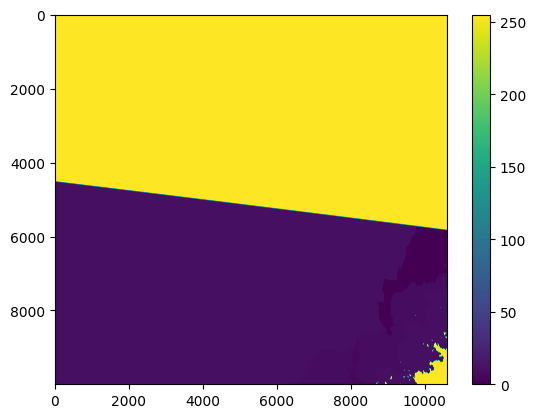

In [10]:
plt.imshow(a)
plt.colorbar()

In [25]:
a

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [ 10.,  10.,  10., ..., 255., 255., 255.],
       [ 10.,  10.,  10., ..., 255., 255., 255.],
       [ 10.,  10.,  10., ..., 255., 255., 255.]], dtype=float32)

In [11]:
np.unique(a)

array([  0.,   5.,   8.,  10., 255.], dtype=float32)

In [23]:
segmentation_mask_uint8 = a.astype(np.uint8)


In [27]:
import cv2
cv2.imwrite('segmentation_mask.png', segmentation_mask_uint8)


True

In [34]:
img = Image.fromarray(segmentation_mask_uint8, 'L')

# Save the image
img.save('segmentation_mask.png')

In [37]:
c = cv2.imread('segmentation_mask.png',cv2.IMREAD_GRAYSCALE)

In [41]:
Image.open('segmentation_mask.png',mode='L')

ValueError: bad mode 'L'

In [38]:
c.shape

(9998, 10601)

In [40]:
np.unique(c)

array([  0,   5,   8,  10, 255], dtype=uint8)

In [22]:
np.unique(pix)

array([  0,  67, 127], dtype=uint8)

In [43]:
a.shape

(9998, 10601)

In [44]:
# Reshape the array to add a new dimension for the channels
arr_channels = a[:, :, np.newaxis]

# Duplicate the values along the new channel dimension
arr_rgb = np.concatenate((arr_channels, arr_channels, arr_channels), axis=2)


In [48]:
arr_rgb

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[ 10.,  10.,  10.],
        [ 10.,  10.,  10.],
        [ 10.,  10.,  10.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[ 10.,  10.,  10.],
        [ 10.,  10.,  10.],
        [ 10.,  10.,  10.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[ 10.,  10.,  10.],
        [ 10.,  10.,  10.],
        [ 10.,  

In [49]:
cv2.imwrite('segmentation_mask.png',arr_rgb)

True

In [15]:
import cv2
import matplotlib.pyplot as plt
e = cv2.imread('/home/m32patel/projects/def-dclausi/AI4arctic/dataset/ai4arctic_raw_train_v3_segmaps/S1B_EW_GRDM_1SDH_20211108T120121_20211108T120221_029496_038533_11EE_icechart_dmi_202111081200_Qaanaaq_RIC_SIC.png', cv2.IMREAD_GRAYSCALE)

In [16]:
np.unique(e)

array([  0,   2,   3,   4,   5,   6,   9,  10, 255], dtype=uint8)

In [17]:
e = e.astype(np.float16)
e[e==255]=np.nan

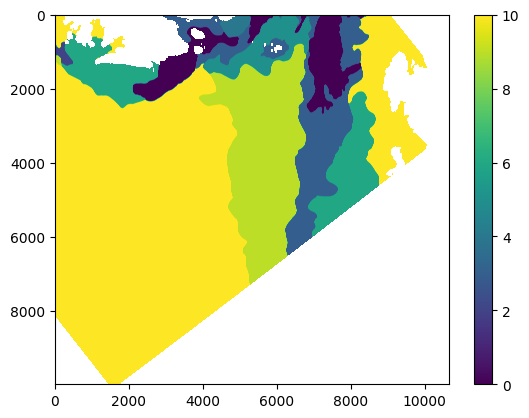

In [18]:
plt.imshow(e)
plt.colorbar()

In [55]:
import os

In [56]:
folder_path = '/home/m32patel/projects/def-dclausi/AI4arctic/dataset/ai4arctic_raw_train_v3'

In [57]:
files = [f for f in os.listdir(folder_path) if f.endswith(".nc")]

In [58]:
files

['S1B_EW_GRDM_1SDH_20211108T120121_20211108T120221_029496_038533_11EE_icechart_dmi_202111081200_Qaanaaq_RIC.nc',
 'S1A_EW_GRDM_1SDH_20190105T102726_20190105T102828_025341_02CE03_7680_icechart_cis_SGRDIEA_20190105T1023Z_pl_a.nc',
 'S1B_EW_GRDM_1SDH_20211215T074546_20211215T074646_030033_039606_A7E0_icechart_dmi_202112150745_NorthEast_RIC.nc',
 'S1B_EW_GRDM_1SDH_20181102T212609_20181102T212657_013431_018D9D_90C9_icechart_cis_SGRDIEA_20181102T2123Z_pl_a.nc',
 'S1A_EW_GRDM_1SDH_20180721T120156_20180721T120256_022892_027B98_56D9_icechart_cis_SGRDIMID_20180721T1203Z_pl_a.nc',
 'S1A_EW_GRDM_1SDH_20181018T121002_20181018T121102_024190_02A56A_C5BD_icechart_cis_SGRDIEA_20181018T1207Z_pl_a.nc',
 'S1A_EW_GRDM_1SDH_20190929T140504_20190929T140604_029237_03524F_C6B1_icechart_cis_SGRDIHA_20190929T1356Z_pl_a.nc',
 'S1A_EW_GRDM_1SDH_20181111T121402_20181111T121502_024540_02B161_E54F_icechart_cis_SGRDIFOXE_20181111T1209Z_pl_a.nc',
 'S1B_EW_GRDM_1SDH_20190228T214234_20190228T214259_015152_01C55A_67BA_ice

In [47]:
import mmcv
import cv2
import numpy as np


# Define the transformation
transform = mmcv.transforms.processing.RandomResize(
    scale=(2048, 512),
    ratio_range=(0.5, 2.0),
    keep_ratio=True)

# Load an image using OpenCV
image_path = '/home/m32patel/projects/def-dclausi/AI4arctic/m32patel/mmsegmentation/computecanada/catto.jpg'
img = cv2.imread(image_path)

results = {}
results['img'] = img
print(img.shape)

(5443, 3629, 3)


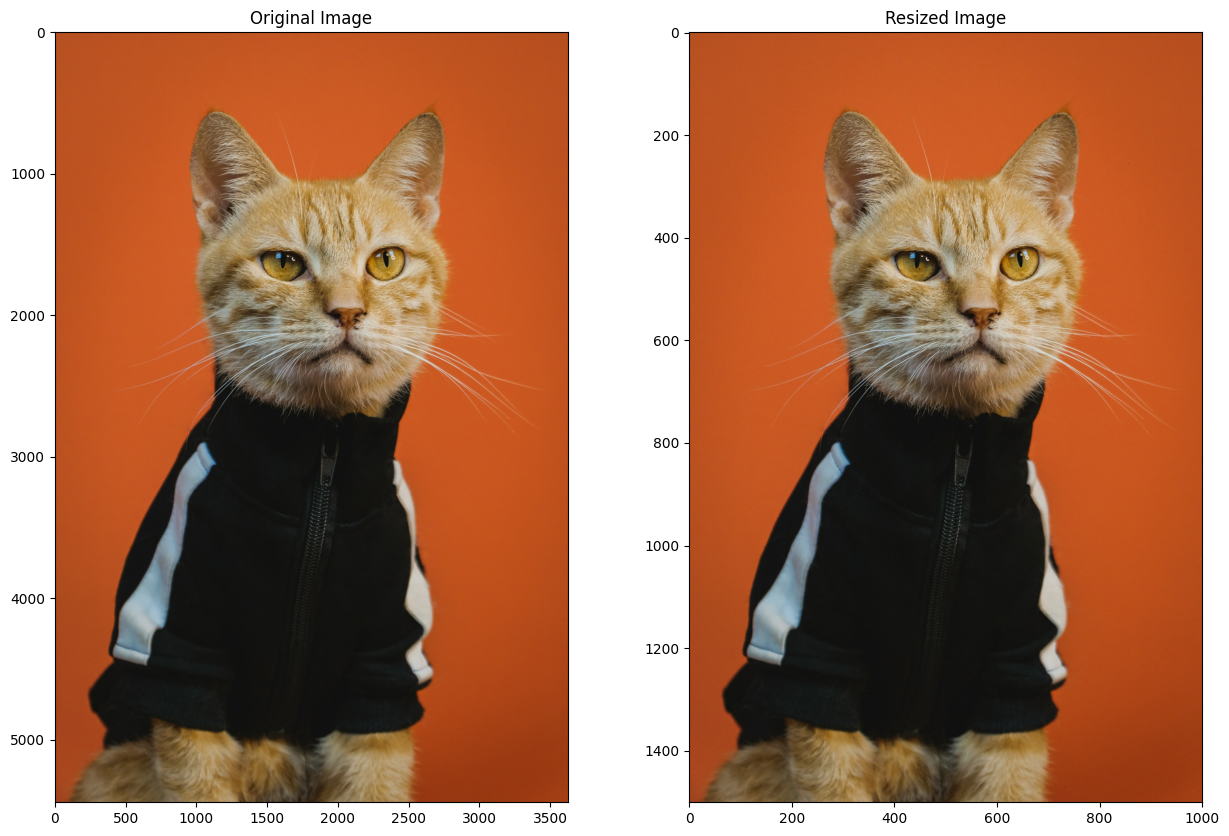

(4004, 1001)
(0.2758335629650041, 0.2757670402351644)
(1501, 1001)


In [48]:


# Apply the transformation to the image
# Note that MMCV expects the image in HWC format (BGR)
results_resized = transform.transform(results)
img_resized = results_resized['img']
# Convert the image to RGB for visualization
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Display the original and resized images using Matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[1].imshow(img_resized)
axs[1].set_title('Resized Image')
plt.show()


print(results_resized['scale'])
print(results_resized['scale_factor'])
print(results_resized['img_shape'])


In [41]:
results_resized.keys()

dict_keys(['img', 'scale', 'img_shape', 'scale_factor', 'keep_ratio'])

In [1]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

wandb: Currently logged in as: m32patel (mmwhale). Use `wandb login --relogin` to force relogin


acc,▁▃▄▇▆▆██
loss,█▅▂▂▂▂▂▁
acc,0.91668
loss,0.05403
